In [1]:
import urllib
import random
import gzip
import math
import numpy
import string
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.optimize
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# PreProcessing Methods

In [3]:
#PreProcessing methods
userDict = {}
userIndex=0
bookDict = {}
bookIndex=0
def getUserId(key):
  if key not in userDict.keys():
    global userIndex
    userIndex=userIndex+1
    userDict[key] = userIndex
    return userIndex
  return userDict[key]
def getBookId(key):
  if key not in bookDict.keys():
    global bookIndex
    bookIndex=bookIndex+1
    bookDict[key] = bookIndex
    return bookIndex
  return bookDict[key]
def preProcess(val):
  val["user_id"] = getUserId(val["user_id"])
  val["book_id"] = getBookId(val["book_id"])
  del val["review_id"]
  del val["date_added"]
  del val["date_updated"]
  del val["read_at"]
  del val["started_at"]
  del val["n_votes"]
  del val["n_comments"]
  return val

In [4]:
f = gzip.open("/content/drive/MyDrive/Final Project/young_adult_10000.json.gz")
dataset = []
for l in f:
    dataset.append(preProcess(eval(l)))
random.shuffle(dataset)
dataTrain = dataset[:9000]
dataTest = dataset[9000:]
df = pd.DataFrame (dataset, columns = ['user_id', 'book_id',  'rating'])

In [5]:
df

,user_id,book_id,rating
0,494,3222,3
1,480,2174,5
2,477,924,0
3,243,2354,5
4,66,949,5
...,...,...,...
9995,34,344,5
9996,698,2221,4
9997,402,521,3
9998,303,1415,3


In [6]:
df.describe()

,user_id,book_id,rating
count,10000.000000,10000.000000,10000.000000
mean,349.337300,1728.146700,3.755500
std,204.133854,1443.718744,1.245662
min,1.000000,1.000000,0.000000
25%,162.000000,389.000000,3.000000
50%,367.000000,1396.500000,4.000000
75%,506.000000,2824.000000,5.000000
max,715.000000,4980.000000,5.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  10000 non-null  int64
 1   book_id  10000 non-null  int64
 2   rating   10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [8]:
df.isnull().sum()

user_id    0
book_id    0
rating     0
dtype: int64

Text(0.5, 1.0, 'Rating Distribution')

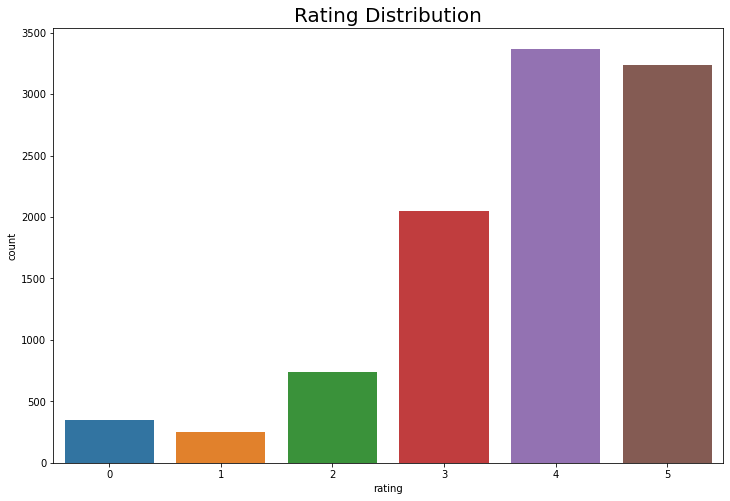

In [10]:
plt.figure(figsize=(12,8))
sns.countplot(x='rating',data=df)
plt.title('Rating Distribution',size=20)

# Bag of Words Approach

In [ ]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)

for d in dataset:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

sorted_counts = sorted(wordCount.items(), key=lambda x:x[1])[::-1]

counts = [(i[1], i[0]) for i in sorted_counts]

words = [x[1] for x in counts[:1000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [ ]:
def feature(datum):
    feat = [0]*len(words)    
    # removing punctuation from review
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])    
    # adding word counts to feature
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1)
    return feat
def accuracy(y, predictions):
    correct = predictions == y 
    acc = sum(correct) / len(correct)
    return acc

In [ ]:
X = [feature(d) for d in dataset]
y = [d['rating'] for d in dataset]

Xtrain = X[:9*len(X)//10]
ytrain = y[:9*len(y)//10]
Xtest = X[9*len(X)//10:]
ytest = y[9*len(y)//10:]

In [ ]:
# Training a model for Logistic Regression
mod = linear_model.LogisticRegression(C=1)
mod.fit(Xtrain,ytrain)
predictions = mod.predict(Xtest)
acc = accuracy(ytest, predictions)

In [ ]:
print('The accuracy for Logistic Regression for Bag of Words approach - \n', acc*100, '%')

The accuracy for Logistic Regression for Bag of Words approach - 
 45.5 %


In [ ]:
# Training a model for Linear Regression
mod1 = linear_model.LinearRegression()
mod1.fit(Xtrain,ytrain)
predictions1 = mod1.predict(Xtest)
mse1 = mean_squared_error(predictions1, ytest)
mape_1 = mean_absolute_percentage_error(predictions1, ytest)*100

In [ ]:
print('The Mean Squared Error of LInear Regression for Bag of Words approach - \n', mse1, '\n')
print('The Mean absolute percentage error of Linear Regression for Bag of Words approach - \n', mape_1)

The Mean Squared Error of LInear Regression for Bag of Words approach - 
 1.5754416572189098 

The Mean absolute percentage error of Linear Regression for Bag of Words approach - 
 36.60850676472431


# Final Approach - Jaccard Similarity

In [ ]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
ratingDict = {} # To retrieve a rating for a specific user/item pair

for d in dataTrain:
    user,item = d['user_id'], d['book_id']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratingDict[(user,item)] = d['rating']

In [ ]:
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)
    
for d in dataTrain:
    user,item = d['user_id'], d['book_id']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)


In [ ]:
# From the pseudo code for jaccard similarity
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom
    
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['book_id']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        ratingMean = sum([d['rating'] for d in dataTrain]) / len(dataTrain)
        return ratingMean
    

In [ ]:
predictions2 = [predictRating(d['user_id'], d['book_id']) for d in dataTest]
labels = [d['rating'] for d in dataTest]
mse2 = mean_squared_error(predictions2, labels)
mape_2 = mean_absolute_percentage_error(predictions2, labels)*100

In [ ]:
print('The Mean Squared Error for Jaccard Similarities - \n', mse2, '\n')
print('The Mean absolute percentage error for Jaccard Similarities - \n', mape_2)

The Mean Squared Error for Jaccard Similarities - 
 1.8375712166843186 

The Mean absolute percentage error for Jaccard Similarities - 
 31.011538168802392
